In [2]:
import pandas as pd
import folium
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
df_fastfood = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood.csv')
df_pollution = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/pollution.csv')
df_geo = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/US_GeoCode.csv')
df_heart = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/heart_2018.csv')

df_subset_fastfood = df_fastfood[["num", "State", "latitude", "longitude", "name"]]
df_subset_pollution = df_pollution[["Year", "State", "O3 Mean", "CO Mean", "SO2 Mean", "NO2 Mean"]]
df_subset_GEO = df_geo[["latitude", "longitude", "State"]]
df_subset_heart = df_heart[["YEAR", "State", "RATE", "DEATHS"]]

# Dizionario per mappare le sigle delle province ai loro nomi completi
province_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

# Sostituisci le sigle delle province con i loro nomi completi
df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)

/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_8035/2725696461.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_8035/2725696461.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)


**prendiamo dai dataset solamente quelli del 2018**

In [4]:
df_pollution_2018 = df_subset_pollution[df_subset_pollution['Year'] == 2018]
df_pollution_2018 = df_pollution_2018.groupby('State').mean()
df_heart_2018 = df_subset_heart[df_subset_heart['YEAR'] == 2018]

MERGE DEI DATASET PER RENDERLI SFRUTTABILI USANDO LA MAPPA

In [ ]:
#fastfood_df = pd.merge(df_subset_fastfood, df_subset_GEO, left_on="State", right_on="State", how="inner")
#fastfood_df = fastfood_df.sort_values(by='State')
#heart_df = pd.merge(df_heart_2018, df_subset_GEO, left_on="State", right_on="State", how="inner")
#pollution_df = pd.merge(df_pollution_2018, df_subset_GEO, left_on="State", right_on="State", how="inner")

# me li salvo così ci lavoro meglio
#pollution_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/pollution_completo.csv', index=False)
#fastfood_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/fastfood_completo.csv', index=False)
#heart_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/heart_completo.csv', index=False)

CI SERVE SOLAMENTE O3 (OZONO TROPOSFERICO) AL FINE DEL NOSTRO STUDIO

LASCIO DI SEGUITO IL LINK:

https://www.escardio.org/The-ESC/Press-Office/Press-releases/ozone-pollution-is-linked-with-increased-hospitalisations-for-cvd#:~:text=Compared%20to%20two%2Dday%20average,6.52%25%20for%20acute%20myocardial%20infarction.

COSTRUISCO LA MAPPA DEL RAPPORTO DELLE MORTI PER INFARTO PER TROVARE UNA CORRELAZIONE

In [6]:
heart_data = pd.read_csv('heart_completo.csv')
# Raggruppa i dati per stato e calcola la media del tasso di mortalità
state_rate_mean = heart_data.groupby('State')['RATE'].mean().reset_index()

# Crea la mappa 
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=False, scrollWheelZoom=False)

usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',     
        'weight': 1,          
        'fillColor': 'pink',  
        'fillOpacity': 0.5    
    }
).add_to(m)

# Crea una mappa basata sulla media del tasso di mortalità per stato
choropleth = folium.Choropleth(
    geo_data='/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA 
    name='choropleth',
    data=state_rate_mean,
    columns=['State', 'RATE'],
    key_on='feature.properties.name',  
    fill_color='YlOrRd',  
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Heart attack',
    nan_fill_color='gray',  
    nan_fill_opacity=0.4,
    bins=5,  
    reset=True,
    overlay=True,
    control=True,
    show=True  
).add_to(m)
#legenda
choropleth.add_to(m)
folium.LayerControl().add_to(m)

m

In [7]:
pollution_data = pd.read_csv('pollution_completo.csv')
state_rate_mean = pollution_data.groupby('State')['O3 Mean'].mean().reset_index()

m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=False, scrollWheelZoom=False)

usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',      
        'weight': 1,           
        'fillColor': 'pink',   
        'fillOpacity': 0.5     
    }
).add_to(m)

choropleth = folium.Choropleth(
    geo_data='/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA 
    name='choropleth',
    data=state_rate_mean,
    columns=['State', 'O3 Mean'],
    key_on='feature.properties.name',  
    fill_color= 'Blues',  
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='O3 pollution',
    nan_fill_color='gray',
    nan_fill_opacity=0.4, 
    bins=5,  
    reset=True,
    overlay=True,
    control=True,
    show=True  
).add_to(m)

# Aggiungi legenda interattiva
choropleth.add_to(m)

# Aggiungi il controllo della legenda alla mappa
folium.LayerControl().add_to(m)

# Visualizza la mappa
m

ORA PROCEDEREMO CON LO STUDIO DELLE CENTRALITà DEI NODI


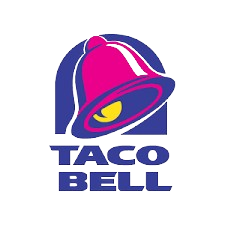
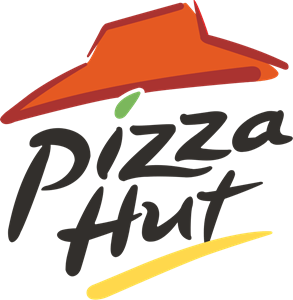
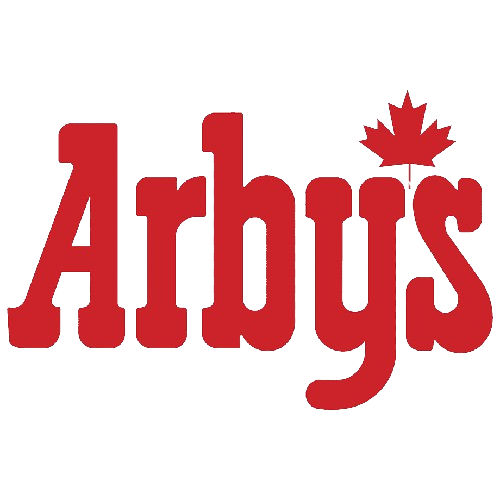
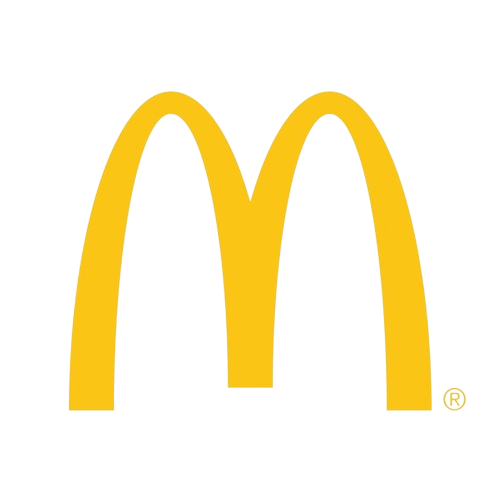
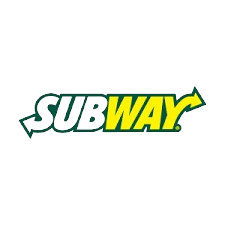
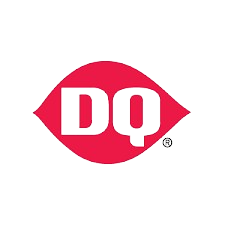
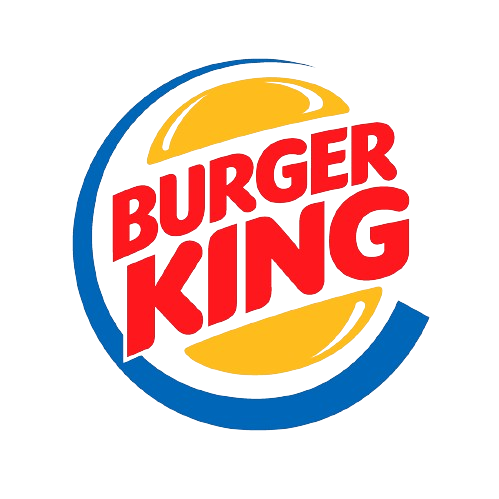
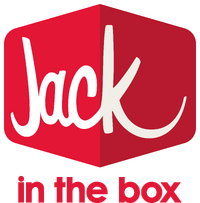
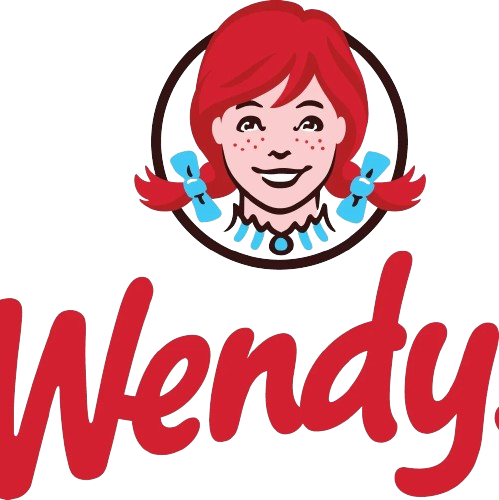
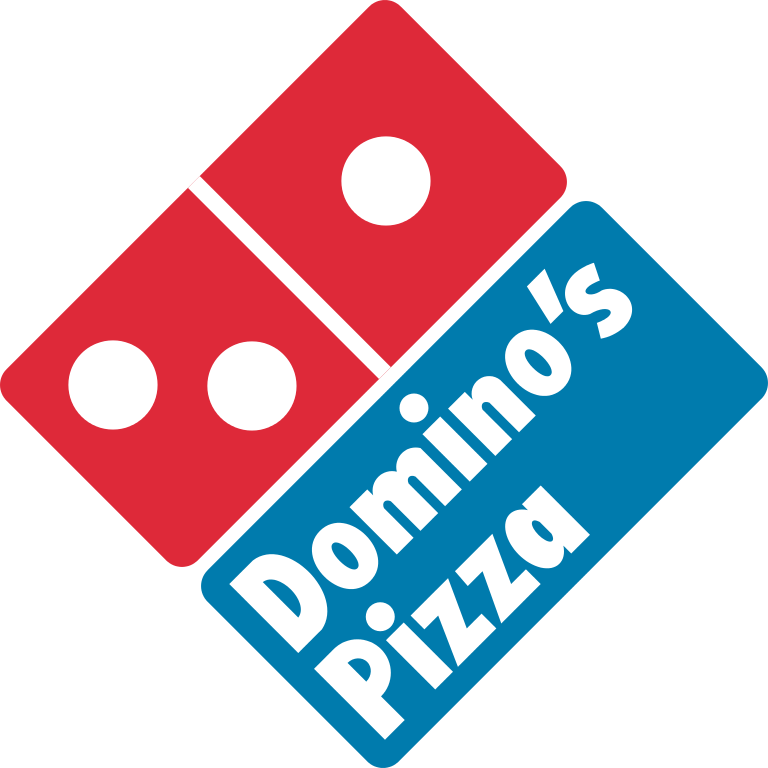

In [8]:
# Leggiamo il file CSV e otteniamo i 10 fast food più frequenti
fastfood_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv') 
top_fastfood = fastfood_df['name'].value_counts().head(10).index.tolist()
altri_fastfood = fastfood_df[~fastfood_df['name'].isin(top_fastfood)]

G = nx.Graph()

# Apriamo il file e aggiungiamo nodi e collegamenti al grafo
with open('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv', 'r') as file: 
    next(file)  
    for line in file:
        _, State, _, _, name, _, _ = line.strip().split(',')
        if name in top_fastfood:
            G.add_node(name, type='top_fastfood')
            G.add_node(State, type='state')
            G.add_edge(name, State)

# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=True, scrollWheelZoom=False)

# Carica il file GeoJSON dei confini degli stati degli USA
usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',    
        'weight': 1,         
        'fillColor': 'pink', 
        'fillOpacity': 0.5   
    }
).add_to(m)

state_boundaries.add_to(m)
randomCoordinates=[]

# Funzione per generare coordinate casuali intorno alla mappa americana
def random_coordinates_around_usa(num_points):
    lat_center = 37.0902
    lon_center = -95.7129
    # ellisse che circonda gli Stati Uniti (approssimativi)
    lat_semi_major_axis = 24
    lon_semi_major_axis = 57
    angle_step = 2 * math.pi / num_points
    random_coordinates = []
    
    # Genera coordinate equidistanti lungo l'ovale
    for i in range(num_points):
        angle = i * angle_step
        lat = lat_center + lat_semi_major_axis * math.cos(angle)
        lon = lon_center + lon_semi_major_axis * math.sin(angle)
        random_coordinates.append((lat, lon))
    
    return random_coordinates

num_points = 11  
coordinates = random_coordinates_around_usa(num_points)


altri_fastfood_node = coordinates[0]
folium.Marker(
    location=altri_fastfood_node,
    popup='<b>Altri Fast Food</b>',  
    icon=folium.Icon(color='green')
).add_to(m)


# Aggiungi i nodi fast food alla mappa come marker con coordinate casuali intorno alla mappa americana
i=1
for node in G.nodes():
    iconPath="Logos/" + node + ".png"
    if G.nodes[node]['type'] == 'top_fastfood':
        folium.Marker(
            location=coordinates[i],
            popup=node,
            icon=folium.CustomIcon(icon_image=iconPath, icon_size=(55,55))
        ).add_to(m)
        i+=1

for state in G.nodes():
    if G.nodes[state]['type'] == 'state':
        state_loc = (
            fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0],
            fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0]
        )
        folium.CircleMarker(
            location=state_loc,
            radius=0.01,
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.7
        ).add_to(m)

for state in G.nodes():
    i=1
    if G.nodes[state]['type'] == 'state':
        state_loc = (fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0], fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0])
        for fastfood_name in top_fastfood:
            fast_food_loc = (coordinates[i][0], coordinates[i][1])
            folium.PolyLine([fast_food_loc, state_loc], color="grey", weight=0.6, opacity=0.7).add_to(m)
            i+=1

# 'altri_fastfood_node' 
for state in G.nodes():
    if G.nodes[state]['type'] == 'state':
        state_loc = (fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0], fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0])
        folium.PolyLine([altri_fastfood_node, state_loc], color="grey", weight=0.6, opacity=0.7).add_to(m)
m

In [ ]:
ff_df = pd.read_csv('fastfood_completo.csv')
fastfood_per_state = ff_df['State'].value_counts()
print(fastfood_per_state)

CENTRALITà DEL GRADO DEI NODI STATO IN BASE AI FASTFOOD ENTRANTI

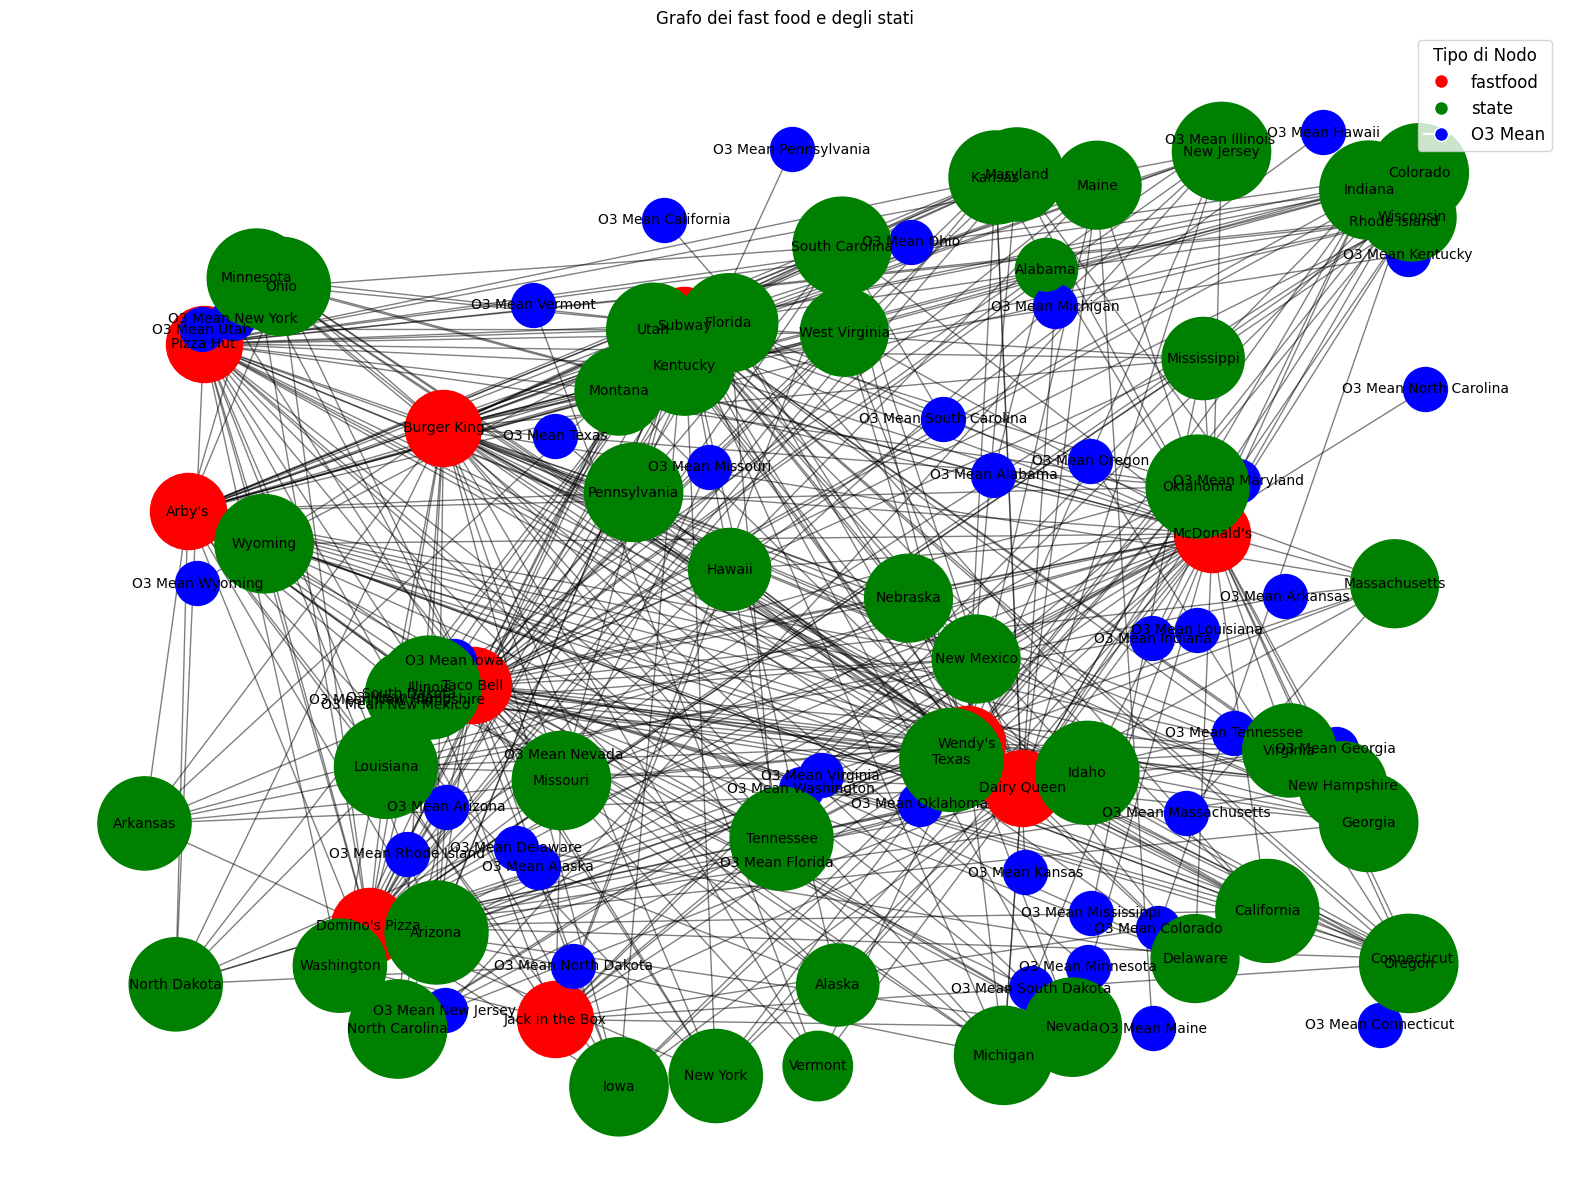

Gli stati con il 20% di grado di centralità del grado del nodo maggiore della media sono:
Arizona
California
Idaho
Illinois
Louisiana
Oklahoma
Tennessee
Texas


Gli stati con il 20% di centralità del grado del nodo minore della media sono:
Alabama
Alaska
Hawaii
Mississippi
Rhode Island
Vermont


In [20]:
pollution_df = pd.read_csv('pollution_completo.csv')
fastfood_df = pd.read_csv('fastfood_completo.csv')

G = nx.Graph()

# Aggiunta dei nodi per i top fast food e gli stati
top_fastfood = fastfood_df['name'].value_counts().head(10).index.tolist()
for fastfood in top_fastfood:
    G.add_node(fastfood, type='fastfood')

for state in fastfood_df['State'].unique():
    G.add_node(state, type='state')

for state in pollution_df['State'].unique():
    G.add_node('O3 Mean ' + state, type='O3 Mean')

# Aggiunta degli archi tra i top fast food e gli stati
for _, row in fastfood_df.iterrows():
    if row['name'] in top_fastfood:
        G.add_edge(row['name'], row['State'])

# Aggiunta degli archi tra i nodi 'O3 Mean' e i nodi 'state'
for _, row in pollution_df.iterrows():
    if row['State'] in G.nodes():
        G.add_edge('O3 Mean ' + row['State'], row['State'], weight=row['O3 Mean'])

# Calcolo della centralità del grado
degree_centrality = nx.degree_centrality(G)

# Creazione del DataFrame con la centralità del grado
state_centrality_df = pd.DataFrame([
    {'Node': node, 'DegreeCentrality': centrality} 
    for node, centrality in degree_centrality.items() 
    if G.nodes[node]['type'] == 'state'
])

# Visualizzazione del grafo
node_colors = {'fastfood': 'red', 'state': 'green', 'O3 Mean': 'blue'}

plt.figure(figsize=(20, 15))
pos = nx.random_layout(G)

# Calcoliamo la dimensione dei nodi degli stati basata sul grado dei nodi (numero di archi in ingresso)
state_node_sizes = [500 * G.degree(state) for state in G.nodes() if G.nodes[state]['type'] == 'state']

nx.draw_networkx_nodes(G, pos, nodelist=top_fastfood, node_color='red', node_size=3000)
nx.draw_networkx_nodes(G, pos, nodelist=fastfood_df['State'].unique(), node_color='green', node_size=2000)
nx.draw_networkx_nodes(G, pos, nodelist=['O3 Mean ' + state for state in pollution_df['State'].unique()], node_color='blue', node_size=1000)
nx.draw_networkx_nodes(G, pos, nodelist=[state for state in G.nodes() if G.nodes[state]['type'] == 'state'], node_color='green', node_size=state_node_sizes)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Legenda
legend_entries = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=10) 
                  for label, color in node_colors.items()]
plt.legend(handles=legend_entries, title='Tipo di Nodo', title_fontsize='large', fontsize='large')

plt.title('Grafo dei fast food e degli stati')
plt.axis('off')
plt.show()

# Analisi della centralità del grado
mean_degree_centrality = state_centrality_df['DegreeCentrality'].mean()
important_states = []

for _, row in state_centrality_df.iterrows():
    if row['DegreeCentrality'] > mean_degree_centrality * 1.20:
        important_states.append(row['Node'])

print("Gli stati con il 20% di grado di centralità del grado del nodo maggiore della media sono:")
for state in important_states:
    print(state)
print("\n")

not_important_states = []

for _, row in state_centrality_df.iterrows():
    if row['DegreeCentrality'] < mean_degree_centrality * 0.8: 
        not_important_states.append(row['Node'])

print("Gli stati con il 20% di centralità del grado del nodo minore della media sono:")
for state in not_important_states:
    print(state)

CALCOLO DELLA CENTRALITà DEGLI AUTOVETTORI 

In [10]:
# Calcolo della centralità degli autovettori per tutti i nodi nel grafo G con più iterazioni
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=200)

# Filtraggio dei nodi di tipo 'State'
state_eigenvector_centrality = {node: centrality for node, centrality in eigenvector_centrality.items() if G.nodes[node]['type'] == 'state'}

# Creazione di un DataFrame per la centralità degli autovettori
state_eigenvector_centrality_df = pd.DataFrame(state_eigenvector_centrality.items(), columns=['Node', 'EigenvectorCentrality'])

# Calcolo della media della centralità degli autovettori
mean_eigenvector_centrality = state_eigenvector_centrality_df['EigenvectorCentrality'].mean()

print("Gli stati con il 18% di centralità degli autovettori maggiore della media sono:")
important_states_eigenvector = state_eigenvector_centrality_df[state_eigenvector_centrality_df['EigenvectorCentrality'] > mean_eigenvector_centrality * 1.178]['Node']
print(important_states_eigenvector)
print("\n")
print("Gli stati con il 18% di centralità degli autovettori minore della media sono:")
not_important_states_eigenvector = state_eigenvector_centrality_df[state_eigenvector_centrality_df['EigenvectorCentrality'] < mean_eigenvector_centrality * 0.8]['Node']
print(not_important_states_eigenvector)

Gli stati con il 18% di centralità degli autovettori maggiore della media sono:
2        Arizona
4     California
11         Idaho
12      Illinois
17     Louisiana
35      Oklahoma
41     Tennessee
42         Texas
Name: Node, dtype: object


Gli stati con il 18% di centralità degli autovettori minore della media sono:
0          Alabama
1           Alaska
10          Hawaii
23     Mississippi
38    Rhode Island
44         Vermont
Name: Node, dtype: object


GRAFICI (ISTOGRAMMA) CORRELAZIONE TOP STATI (ASSE X) BLU O3 E ROSSO HEART ATTACK, PRIMA DI FARE QUESTO ABBIAMO NORMALIZZATO PER LA FORMULA MAX-MIN CHE CI PERMETTE DI CORRELARE MEGLIO I DUE VALORI, RIPORTO DI SEGUITO LA FORMULA.

X(norm)=(X-X(min)/X(max)-X(min))*(max-min)+min

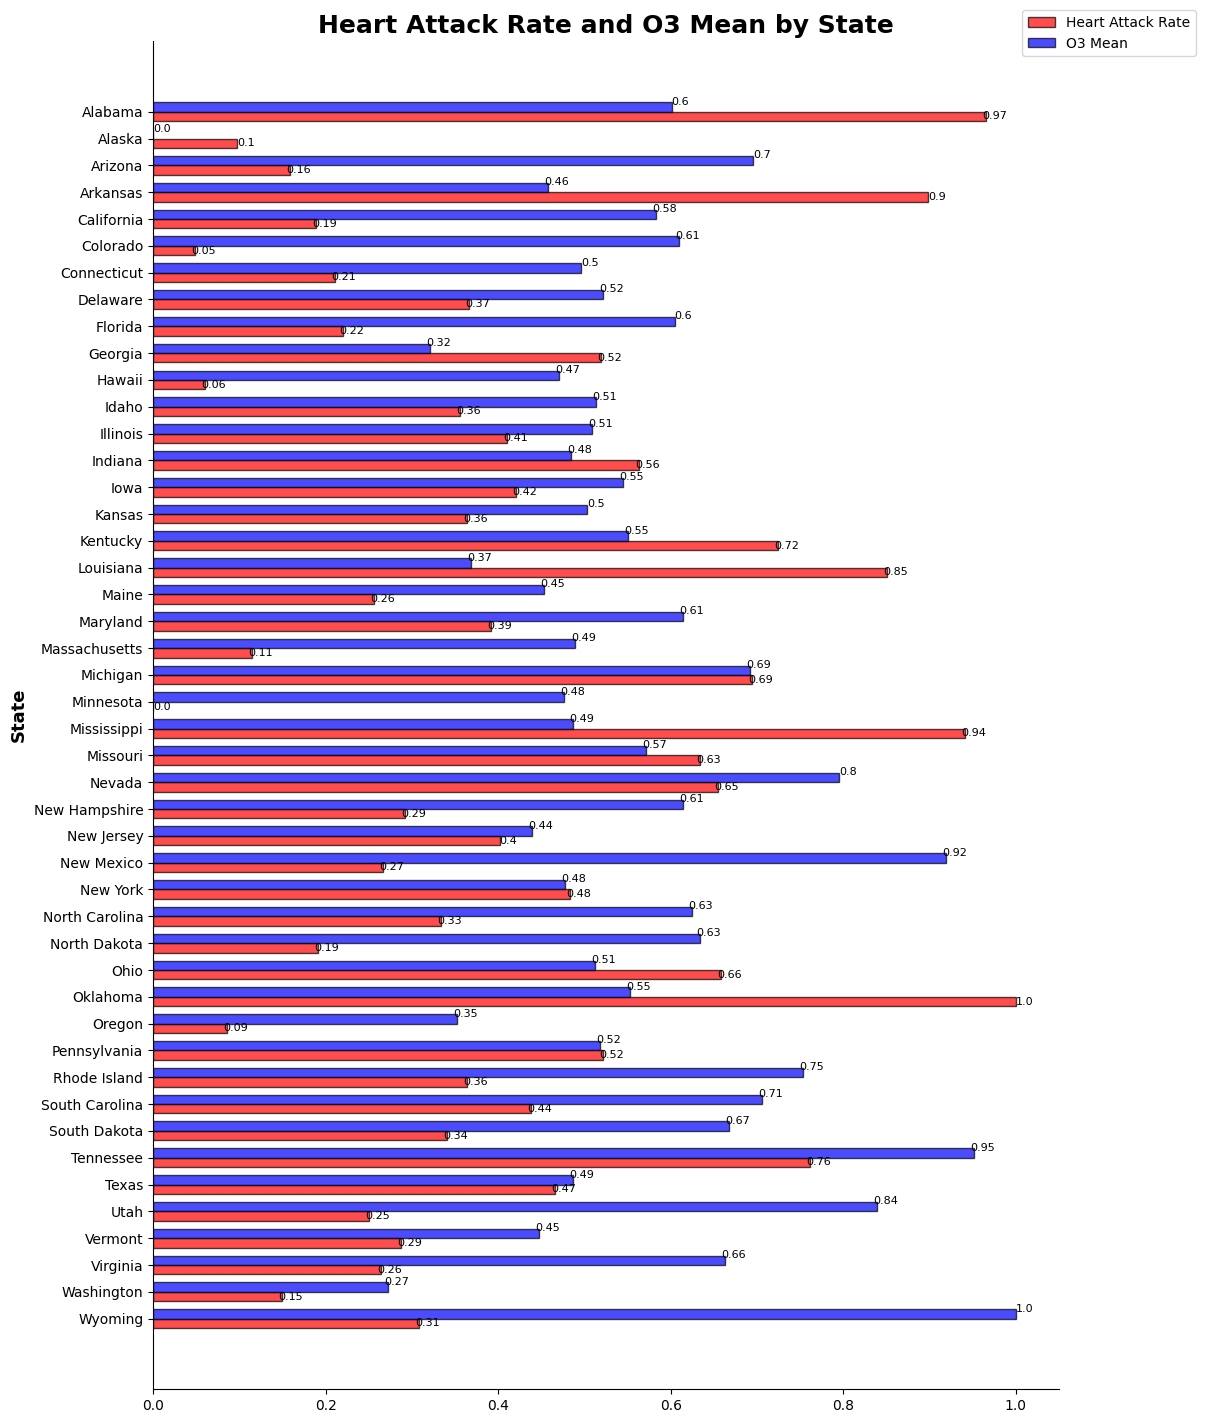

In [11]:
heart_attack_completo = pd.read_csv('heart_completo.csv')
pollution_completo = pd.read_csv('pollution_completo.csv')

# Unisci i dataset utilizzando lo stato come chiave primaria
merged_data = pd.merge(heart_attack_completo, pollution_completo, on='State')

# Seleziona solo le colonne necessarie
merged_data = merged_data[['State', 'RATE', 'O3 Mean']]
merged_data.sort_values(by='State', ascending=False,  inplace=True)

# Trova il valore massimo e minimo di RATE e O3 Mean
max_rate = merged_data['RATE'].max()
min_rate = merged_data['RATE'].min()
max_o3_mean = merged_data['O3 Mean'].max()
min_o3_mean = merged_data['O3 Mean'].min()

# Normalizza i valori di RATE e O3 Mean utilizzando la formula di normalizzazione massimo-minimo
merged_data['RATE_Normalized'] = ((merged_data['RATE'] - min_rate) / (max_rate - min_rate)) * (1 - 0) + 0
merged_data['O3 Mean_Normalized'] = ((merged_data['O3 Mean'] - min_o3_mean) / (max_o3_mean - min_o3_mean)) * (1 - 0) + 0

# Crea l'istogramma con doppie barre in orizzontale
plt.figure(figsize=(12, 15)) 
bar_height = 0.35
index = range(len(merged_data['State']))
plt.barh(index, merged_data['RATE_Normalized'], bar_height, label='Heart Attack Rate', color='red', alpha=0.7, edgecolor='black')
plt.barh([i + bar_height for i in index], merged_data['O3 Mean_Normalized'], bar_height, label='O3 Mean', color='blue', alpha=0.7, edgecolor='black')
plt.ylabel('State', fontweight='bold', fontsize=13)  
plt.title('Heart Attack Rate and O3 Mean by State', fontweight='bold', fontsize=18)
plt.yticks([i + bar_height / 2 for i in index], merged_data['State'], fontsize=10)  

# Aggiungi i valori normalizzati sopra le barre con maggiore spazio tra i valori e le barre e con un font più piccolo
for i, rate_normalized, o3_mean_normalized in zip(index, merged_data['RATE_Normalized'], merged_data['O3 Mean_Normalized']):
    plt.text(rate_normalized + 0.01, i, str(round(rate_normalized, 2)), ha='center', va='center', color='black', fontsize=8)
    plt.text(o3_mean_normalized + 0.01, i + bar_height + 0.2, str(round(o3_mean_normalized, 2)), ha='center', va='center', color='black', fontsize=8) 
plt.legend(loc='upper left', bbox_to_anchor=(0.85, 0.95), bbox_transform=plt.gcf().transFigure)

# Imposta lo stile degli assi e rimuovi il bordo
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.tight_layout()
plt.show()

visualizzare informazioni correlazioni tra infarti e fastfood (fare forma tabellare)

In [12]:
fastfood_df = pd.read_csv('fastfood_completo.csv')
heart_df = pd.read_csv('heart_completo.csv')

fastfood_df = fastfood_df.groupby('State').size().reset_index(name='count')
heart_fastfood = pd.merge(fastfood_df, heart_df, on="State", how="inner")
heart_fastfood.drop(columns=['YEAR', 'DEATHS', 'latitude', 'longitude'], inplace=True)

#CORRELAZIONE DI PEARSON TRA FASTFOOD E HEART ATTACK
correlation_coefficient= np.corrcoef(heart_fastfood['count'], heart_fastfood['RATE'])[0,1]

print(correlation_coefficient)

-0.00464974111393791


In [15]:
pollution_df = pd.read_csv('pollution_completo.csv')
heart_df = pd.read_csv('heart_completo.csv')

heart_pollution = pd.merge(pollution_df, heart_df, on="State", how="inner")
heart_pollution['O3 Mean'] = heart_pollution['O3 Mean'].round(5)
heart_pollution.drop(columns=['Year', 'DEATHS', 'latitude_y', 'longitude_y', 'CO Mean', 'SO2 Mean', 'NO2 Mean', 'YEAR', 'latitude_x', 'longitude_x'], inplace=True)

#CORRELAZIONE DI PEARSON TRA INQUINAMENTO E HEART ATTACK
correlation_coefficient= np.corrcoef(heart_pollution['O3 Mean'], heart_pollution['RATE'])[0,1]

print(correlation_coefficient)

0.0994089288645418


In [16]:
fastfood_df = pd.read_csv('fastfood_completo.csv')
heart_df = pd.read_csv('heart_completo.csv')
pollution_df = pd.read_csv('pollution_completo.csv')

# Effettua il groupby per lo stato e conta i fast food per stato
fastfood_df = fastfood_df.groupby('State').size().reset_index(name='count')
heart_fastfood = pd.merge(fastfood_df, heart_df, on="State", how="inner")
merged_df = pd.merge(heart_fastfood, pollution_df, on="State", how="inner")

# Calcola una nuova variabile che rappresenta la combinazione di fast food e inquinamento
merged_df['FastFood_Pollution'] = merged_df['count'] * merged_df['O3 Mean']

# Calcola la correlazione di Pearson tra la nuova variabile e gli attacchi di cuore
correlation_coefficient = merged_df[['FastFood_Pollution', 'RATE']].corr().iloc[0, 1]

print("Correlazione tra fast food, inquinamento e attacchi di cuore:", correlation_coefficient)

Correlazione tra fast food, inquinamento e attacchi di cuore: 0.00561998391269942


In [17]:
heart_fastfood_pollution = pd.merge(heart_pollution, heart_fastfood, on="State", how="inner")
heart_fastfood_pollution.drop(columns=['RATE_y'], inplace=True)

# Seleziona le colonne da normalizzare
data_to_normalize = heart_fastfood_pollution[['O3 Mean', 'RATE_x', 'count']]

# Crea un oggetto StandardScaler
scaler = StandardScaler()

normalized_data = scaler.fit_transform(data_to_normalize)
print(normalized_data)

normalized_df = pd.DataFrame(normalized_data, columns=['O3 Mean', 'RATE_x', 'count'])
heart_fastfood_pollution['State'] = heart_fastfood_pollution['State']

# Seleziona solo le colonne numeriche 
numeric_columns = heart_fastfood_pollution.select_dtypes(include=['float64', 'int64'])
# correlazione di Pearson
correlation_matrix = numeric_columns.corr(method='pearson')

print("Matrice di correlazione di Pearson:")
print(correlation_matrix)

[[ 0.22715656  2.14024218 -0.89720133]
 [-3.23154804 -1.21865828 -0.85301369]
 [ 0.76942108 -0.98176741  0.5344784 ]
 [-0.59802859  1.8821372  -0.47299993]
 [ 0.123419   -0.86508981  4.38322237]
 [ 0.27430999 -1.40958525 -0.26973676]
 [-0.37876511 -0.78023338 -0.6895194 ]
 [-0.23023178 -0.17916698 -0.72928828]
 [ 0.2483756  -0.74487653  1.8203389 ]
 [-1.38313331  0.41129237  0.93216721]
 [-0.52729843 -1.36362135 -0.78231346]
 [-0.28210056 -0.2215952  -0.69835693]
 [-0.30567728 -0.00945411  0.86588574]
 [-0.44713759  0.58454092  0.19865229]
 [-0.09584449  0.0329741  -0.41555599]
 [-0.33632701 -0.18623835 -0.59672534]
 [-0.06283708  1.20682142 -0.190199  ]
 [-1.11200105  1.6982816  -0.03112347]
 [-0.62632065 -0.60698483 -0.81324481]
 [ 0.30024438 -0.08016781 -0.16368641]
 [-0.41648786 -1.15501596 -0.01786718]
 [ 0.74584436  1.09014383  0.72890404]
 [-0.48957568 -1.59697654 -0.04437977]
 [-0.43063389  2.04831438 -0.68068187]
 [ 0.05268884  0.85678864 -0.20345529]
 [ 1.34469301  0.93810939

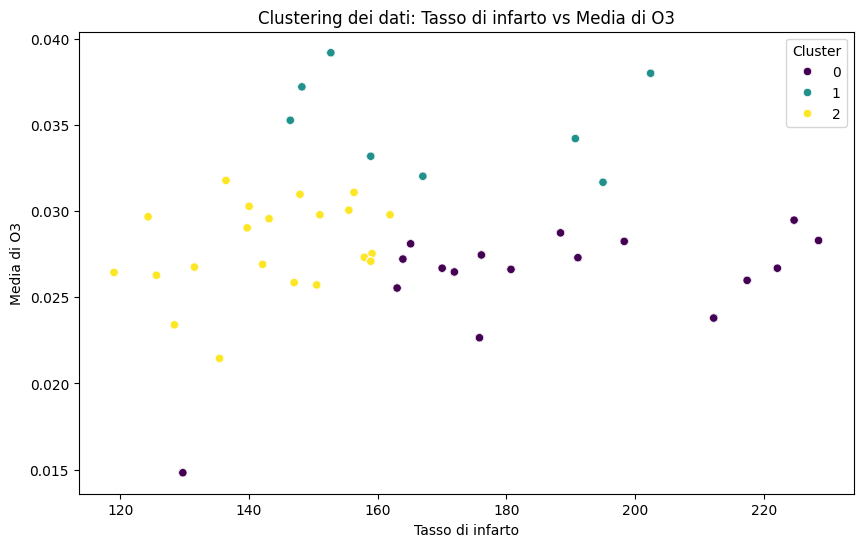

In [18]:
fastfood_df = pd.read_csv('fastfood_completo.csv')
heart_df = pd.read_csv('heart_completo.csv')
pollution_df = pd.read_csv('pollution_completo.csv')

# merge
merged_df = pd.merge(fastfood_df, heart_df, on='State')
merged_df = pd.merge(merged_df, pollution_df[['State', 'O3 Mean']], on='State')

features = ['RATE', 'O3 Mean']

# Normalizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_df[features])

# Applicazione dell'algoritmo K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualizzazione dei cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='RATE', y='O3 Mean', hue='Cluster', palette='viridis')
plt.title('Clustering dei dati: Tasso di infarto vs Media di O3')
plt.xlabel('Tasso di infarto')
plt.ylabel('Media di O3')
plt.legend(title='Cluster')
plt.show()

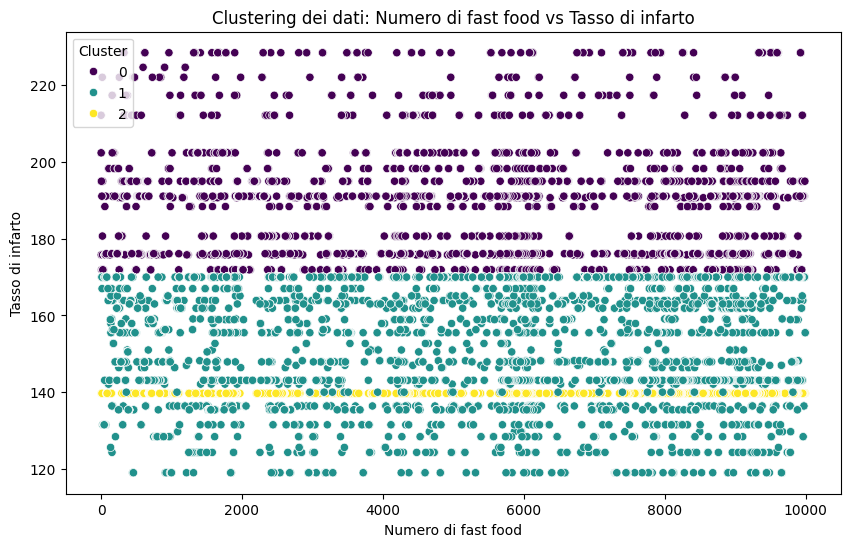

In [19]:
fastfood_df = pd.read_csv('fastfood_count_by_state.csv')
heart_df = pd.read_csv('heart_completo.csv')

merged_df = pd.merge(merged_df, fastfood_df, on='State')

features = ['Record_Count', 'RATE']

# Normalizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_df[features])

# Applicazione dell'algoritmo K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualizzazione dei cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='num', y='RATE', hue='Cluster', palette='viridis')
plt.title('Clustering dei dati: Numero di fast food vs Tasso di infarto')
plt.xlabel('Numero di fast food')
plt.ylabel('Tasso di infarto')
plt.legend(title='Cluster')
plt.show()